In [3]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import random as rand

dir_list = os.listdir('Primary Care Calibration\\Manually Validated Participants')
calList = pandas.read_excel('Primary Care Calibration\\Manually Validated Participants\\Calibration List.xlsx').to_numpy()

inds = np.zeros(len(dir_list)-1)
for i in range(len(dir_list)-1):
    if calList[i, 1]=='Good':
        inds[i] = 1

def dataClean(data, reg=np.array([[0, 1920], [0, 1080]])):
    for l in range(len(data[:, 0])):
        if data[l, 4]<reg[0, 0] or data[l, 4]>reg[0, 1] or data[l, 5]<reg[1, 0] or data[l, 5]>reg[1, 1]:
            data[l, 3] = 0

    validData = np.zeros(shape=(int(sum(data[:, 3])), 6))

    j = 0
    for k in range(len(data[:, 0])):
        if data[k, 3] == 1:
            validData[j, :] = data[k, :]
            j= j + 1
    return validData

def com(data):
    m = len(data[:, 0])
    dataCom = ((data.T  @ np.ones(m)[None].T)/m).T[0]
    return dataCom

In [4]:
sm = np.array([[0, 550], [200, 600]])
speedom = np.array([[820, 1000], [200, 400]])
rv = np.array([[1250, 1900], [540, 800]])
road = np.array([[600, 1050], [400, 550]])
panel = np.array([[1240, 1640], [0, 270]])

def regConv(region, comAvgs, comSDs):
    newReg = region - (np.ones(2)[None].T @ comAvgs[None]).T + 2*(np.array([-1, 1])[None].T @ comSDs[None]).T
    return newReg

comAvgs = np.array([997.388, 460.393])
comSDs = np.array([28.058, 29.206])

newSm = regConv(sm, comAvgs, comSDs)
newSpeedom = regConv(speedom, comAvgs, comSDs)
newRv = regConv(rv, comAvgs, comSDs)
newRoad = regConv(road, comAvgs, comSDs)
newPanel = regConv(panel, comAvgs, comSDs)

def regComs(validData):
    n = len(validData[:, 4])

    avgs = ((validData[:, 4:].T  @ np.ones(n)[None].T)/n).T[0]

    dispMatr = np.ones(len(validData[:, 0]))[None].T @ avgs[None]
    validData[:, 4:] = validData[:, 4:] - dispMatr

    smData = dataClean(validData, newSm)
    validData[:, 3] = np.ones(n)
    speedomData = dataClean(validData, newSpeedom)
    validData[:, 3] = np.ones(n)
    rvData = dataClean(validData, newRv)
    validData[:, 3] = np.ones(n)
    roadData = dataClean(validData, newRoad)
    validData[:, 3] = np.ones(n)
    panelData = dataClean(validData, newPanel)

    m1 = len(smData[:, 4])
    smAvgs = ((smData[:, 4:].T  @ np.ones(m1)[None].T)/m1).T[0]
    m2 = len(speedomData[:, 4])
    speedomAvgs = ((speedomData[:, 4:].T  @ np.ones(m2)[None].T)/m2).T[0]
    m3 = len(rvData[:, 4])
    rvAvgs = ((rvData[:, 4:].T  @ np.ones(m3)[None].T)/m3).T[0]
    m4 = len(roadData[:, 4])
    roadAvgs = ((roadData[:, 4:].T  @ np.ones(m4)[None].T)/m4).T[0]
    m5 = len(panelData[:, 4])
    panelAvgs = ((panelData[:, 4:].T  @ np.ones(m5)[None].T)/m5).T[0]
    
    return np.array([n, m1, m2, m3, m4, m5]), np.array([avgs, smAvgs + avgs, speedomAvgs + avgs, rvAvgs + avgs, roadAvgs + avgs, panelAvgs + avgs])

[[34.25642392 21.95453001]
 [15.23754733 15.13710234]
 [29.31201754 16.78361926]
 [12.90655847  6.62244055]
 [19.07620144 18.06992665]]


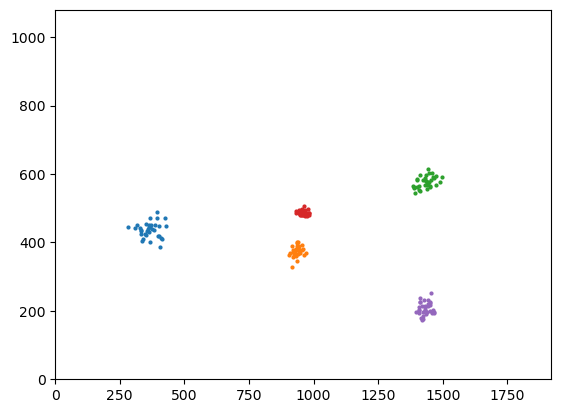

In [ ]:
import statistics as stat
coms = np.zeros(shape=(6, 2, int(sum(inds))))

k=0
for i in range(len(dir_list)-1):
    if inds[i]==1:
        data = pandas.read_csv('Primary Care Calibration\\Manually Validated Participants\\' + str(dir_list[i+1])).to_numpy()
        coms[:, :, k] = regComs(data)
        k = k+1

varInfo = np.zeros(shape=(5, 2))
for j in range(5):
    dispMatr = np.ones(shape=(34))[None].T @ (coms[j+1, :, :] @ np.ones(shape=(34))[None].T/34).T
    centered = coms[j+1, :, :] - dispMatr.T
    covar = centered @ centered.T/33
    varInfo[j, :] = np.sqrt(np.diag(covar))

for i in range(5):
    plt.plot(coms[i+1, 0, :] + comAvgs[0], coms[i+1, 1, :] + comAvgs[1], 'o', markersize=2)

print(varInfo)

plt.xlim(0, 1920); plt.ylim(0, 1080)
plt.show()